# Introduction

---

# Continuing Our Journey with Backpropagation

In this notebook, we are again following Andrej Karpathy's lecture titled "The spelled-out intro to neural networks and backpropagation: building micrograd"

This notebook covers the second half of the lecture.

We continue in our exploration of backpropagation, one of the foundational algorithms behind the training of deep neural networks. As we transition deeper into our study, we'll also familiarize ourselves with PyTorch, a popular deep learning library that's both powerful and user-friendly.

## Enhancing the `Value` Class

To lay the groundwork for our upcoming exercises and simulations, we've made some significant enhancements to the `Value` class:

- **Extended Operations**: We've broadened the range of operations our `Value` objects can handle. Beyond just addition and multiplication, they now support power, division, and subtraction operations. This augmentation not only improves its versatility but also mirrors the diverse operations we encounter in neural network architectures.
  
- **Implicit Conversion**: For the sake of convenience, the methods now automatically convert numerical values into `Value` objects when necessary. This spares us from repeatedly wrapping numbers inside the `Value` class.
  
- **Advanced Mathematical Functions**: We've introduced specialized functions like `tanh` and `exp`, which are frequently used activation functions in neural networks. These functions play a pivotal role in introducing non-linearity to our models, enabling them to capture intricate patterns in data.
  
- **Backward Propagation**: A crucial addition is the `backward` method that employs topological sort to streamline the backpropagation process. This method organizes the nodes in an order that respects the dependencies, ensuring gradients are computed systematically.

### Why These Enhancements?

The primary motivation behind these improvements is to create a more versatile and powerful toolset, paving the way for intricate neural network simulations. As we delve deeper into the domain of deep learning, we'll encounter more complex architectures and computations. These additions to the `Value` class ensure that our foundation is robust enough to support these complexities and provide a smooth learning experience.
---

## Introductory Text for Colab Notebook

In this notebook, we delve into the foundational concepts of neural networks, following Andrej Karpathy's lecture titled "The spelled-out intro to neural networks and backpropagation: building micrograd." By dissecting neural networks into their core mathematical components and operations, we aim to demystify their inner workings and build a fundamental understanding of how they are trained. The main concepts covered are:

1. **Micrograd Overview**: An introduction to the Micrograd library, which serves as an "autograd" engine to efficiently evaluate the gradient of a loss function concerning a neural network's weights.
  
2. **Neural Networks as Mathematical Expressions**: A deep dive into the realization that neural networks are just structured mathematical expressions with a focus on backpropagation as a general concept.

3. **Understanding Derivatives**: A foundational explanation of derivatives, providing a conceptual understanding of their significance in neural network training.

4. **Backward Function & Topological Sort**: Understanding the importance of topological sorting in backpropagation and implementing a backward function for an entire expression graph.

5. **Building a Neural Network in Micrograd**: From constructing individual neurons to building a multi-layer perceptron (MLP), this segment details the process of creating a neural network from the ground up.

6. **Gradient Descent Optimization**: A comprehensive look at the optimization technique vital for training neural networks, detailing its process, challenges, and its real-world implementation in frameworks like PyTorch.

This is one lecture but two notebooks. This is notebook 2.


## The History of Backpropagation

Backpropagation, short for "backward propagation of errors," is a cornerstone of modern neural network training. Its history is a fascinating journey of discovery, rediscovery, and eventual acceptance in the field of artificial intelligence. Let's delve into the significant milestones:

## 1. **Initial Foundations**:
- **1960s**: The idea of training multi-layered networks by propagating error backwards was discussed in works by Bryson and Ho in 1969. However, it was not directly applied to neural networks and was largely overlooked in this context.

## 2. **Recognition and Development**:
- **1970s**: The "delta rule" or "least mean square" algorithm, which is a special case of backpropagation for a single-layered network (perceptron), was popularized by Widrow and Hoff.
- **1982**: Paul Werbos introduced the backpropagation algorithm as we know it today, in the context of neural networks, in his Ph.D. thesis.

## 3. **Popularization**:
- **1986**: The turning point for backpropagation came when Geoffrey Hinton, David Rumelhart, and Ronald Williams published a paper detailing the method. This paper popularized the algorithm within the artificial intelligence community, making it a standard technique for training multi-layer neural networks.

## 4. **Skepticism and Renaissance**:
- **1990s-2000s**: Despite its success, backpropagation and neural networks faced skepticism due to various challenges, including the vanishing gradient problem. During this period, other machine learning techniques like support vector machines gained prominence.
- **Late 2000s**: The tide began to turn with the advent of deep learning. With larger datasets and increased computational power, especially through GPUs, deep neural networks trained with backpropagation started setting benchmark records in various tasks. Pioneers like Geoffrey Hinton, Yann LeCun, and Yoshua Bengio played instrumental roles in this renaissance.

## 5. **Modern Era**:
- **2010s-Present**: Backpropagation, with enhancements and variants, is now the backbone of training deep neural networks. The algorithm underpins the success of deep learning in numerous applications, from computer vision to natural language processing, and has driven a revolution in artificial intelligence.

## Conclusion:

The history of backpropagation serves as a reminder of the non-linear nature of scientific progress. Often, ideas ahead of their time need the alignment of multiple factors – data, computational resources, and algorithmic innovations – to shine. Today, backpropagation stands as a testament to the power of revisiting and building upon past ideas, and its discovery has been pivotal in ushering in the current era of artificial intelligence.

---

# Adding to Value class

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

     # If root is a single Value, wrap it in a list
  # if not isinstance(root, list):
  #   root = [root]

  # nodes, edges = set(root), set()
  # for r in root:
  #   n, e = trace(r)
  #   nodes.update(n)
  #   edges.update(e)

  nodes, edges = trace(root)

  # nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

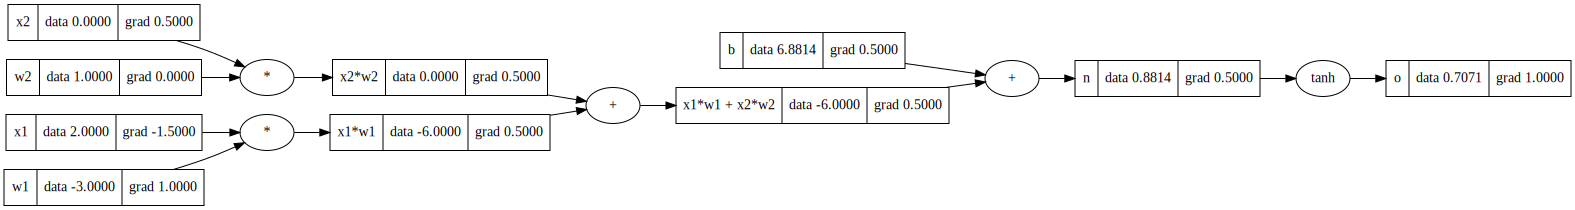

In [ ]:
draw_dot(o)

## Exploring the Flexibility of Neural Network Nodes

In this section of our notebook, we're revisiting the familiar terrain of neural network nodes but with a twist. We've taken our previous neural node and replaced the `tanh` activation with its mathematical expression. By doing this, we're diving deeper into the intricacies of how activation functions work and demonstrating an essential concept in neural network architecture: the modularity and flexibility of nodes.

## Splitting the `tanh` Activation

The hyperbolic tangent or `tanh` function is a frequently used activation function, defined as:

$$
\tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1}
$$

Here, we've broken down the `tanh` function into its constituent mathematical operations. This not only gives us a clearer insight into its workings but also serves as an exercise in understanding how even complex functions can be represented step-by-step in our network.

## Why Is This Important?

1. **Modularity**: One of the core strengths of neural networks is their modular nature. Each node or function can be seen as a building block. By understanding the individual blocks, we can assemble them in various ways to construct sophisticated architectures.

2. **Flexibility**: Neural networks aren't restricted to preset functions or nodes. If you can define a function and its derivative, you can use it in a neural network. This flexibility lets researchers and practitioners experiment with novel architectures tailored to specific problems.

3. **Local Derivative**: No matter how complex a node's operation might seem, as long as we can compute its local derivative, we can integrate it into our backpropagation algorithm. This means we can build and train neural networks using a diverse range of functions, from the simple to the highly intricate.

4. **Freedom of Choice**: When designing a neural network, you're not just picking from a menu of pre-defined options. Understanding the mechanics and mathematics behind standard functions like `tanh` empowers you to design custom nodes that might be better suited to your specific application or dataset.

In conclusion, by dissecting the `tanh` function and manually computing its forward and backward passes, we're not just learning about `tanh`. We're getting a glimpse into the principles that underlie the entire field of neural networks — principles of modularity, flexibility, and the power of the local derivative.

---

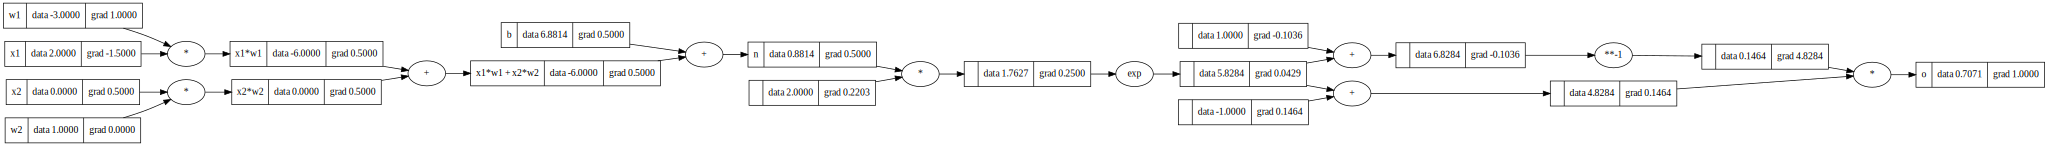

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

# Introducing Pytorch

## Leveraging PyTorch for Neural Network Backpropagation

In this segment, we're transitioning from our handcrafted neural network node implementation to the realm of PyTorch, a powerful deep learning framework. Our goal remains the same: understanding backpropagation. However, with PyTorch, we have a set of tools that can abstract away much of the manual labor, allowing us to focus on the broader conceptual landscape.

## Breaking Down the PyTorch Code:

1. **Tensor Creation**:
    - We start by creating PyTorch tensors for our inputs (`x1`, `x2`), weights (`w1`, `w2`), and bias (`b`). A tensor in PyTorch is a multi-dimensional array, akin to NumPy arrays, but with the added capability to work on GPUs and to facilitate automatic differentiation.
    - The `.double()` method is used to ensure the tensors have double precision.

2. **Gradient Computation**:
    - The `requires_grad=True` property tells PyTorch that we'll want to compute gradients with respect to these variables during the backward pass. This is fundamental for training neural networks as it flags to PyTorch's autograd system that these tensors are trainable parameters.

3. **Defining the Computation Graph**:
    - The line `n = x1*w1 + x2*w2 + b` represents the forward pass of our neuron. PyTorch, under the hood, builds a dynamic computational graph from these operations, recording the operations and tensors in order.

4. **Activation Function**:
    - We then apply the `tanh` activation function using PyTorch's built-in function. This abstracts away the intricacies of the function we manually implemented earlier.

5. **Backward Pass**:
    - Invoking `o.backward()` performs automatic differentiation. PyTorch computes the gradients for all tensors with `requires_grad=True`.

6. **Gradient Inspection**:
    - Finally, we print out the computed gradients. For example, `x2.grad.item()` retrieves the gradient of the loss with respect to `x2`.

## Comparing with Previous Implementation:

- **Abstraction**: While our manual approach meticulously detailed each step of the computation and backpropagation, PyTorch abstracts much of this away. This allows for more complex networks to be built with ease, but it's crucial to understand the underlying principles, as we've studied.
  
- **Efficiency**: PyTorch is optimized for performance. While our manual approach was educational, PyTorch's implementation is designed for speed and can be run on GPUs.

- **Flexibility**: PyTorch's dynamic computation graph means that the graph is built on-the-fly, operation by operation, allowing for more flexible and intricate model architectures.

In summary, transitioning to PyTorch provides a more efficient and flexible platform for neural network experimentation. However, the foundational understanding we've gained from manually building and backpropagating through our network is invaluable, ensuring we can harness the full power of frameworks like PyTorch with clarity and purpose.

---

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o.data.item()

0.7071066904050358

## Neural Networks: A Special Class of Mathematical Expressions

Neural networks, at their core, are intricately woven mathematical structures. Despite the complexity and diversity of architectures we encounter in the field of deep learning, every neural network is fundamentally a composition of simple mathematical functions. This modular architecture allows neural networks to represent a wide variety of functions, making them highly versatile for numerous tasks.

## Understanding the Essence:

1. **Building Blocks**: Each neuron in a neural network can be seen as a small mathematical entity, taking several inputs, multiplying them with their associated weights, summing the results, and then passing the sum through an activation function. This simple computation, when scaled and layered, gives rise to the powerful and complex architectures we see today.

2. **Composition**: At a high level, neural networks are about composing simple functions into more complex ones. This hierarchical composition allows the network to represent intricate and high-dimensional patterns. As data flows through layers, features get more abstract, allowing networks to capture hierarchical patterns in the data.

3. **Trainability**: What sets neural networks apart from other mathematical expressions is their ability to "learn". The weights of the network (its parameters) can be adjusted through optimization techniques (like gradient descent) to minimize the difference between its predictions and the actual data. This iterative adjustment process is guided by backpropagation, which calculates how each weight should be modified.

## Venturing Forward: The Multi-Layered Perceptron (MLP):

As we advance to constructing a 2-layer Multi-Layered Perceptron (MLP) in the next section, it's essential to understand that despite the seeming complexity, the MLP is fundamentally just a series of mathematical functions stacked on top of each other. Each layer captures more abstract representations of the data, allowing for complex decision boundaries and representations to be formed.

In summary, neural networks exemplify the power of simplicity in numbers. By composing simple mathematical functions, layer after layer, and adjusting their parameters based on data, we achieve models that can perform astonishingly complex tasks, from recognizing objects in images to translating languages in real-time.

---

## Building a Neuron with the PyTorch API Style

In the world of deep learning, libraries like PyTorch have standardized the way we create and work with neural network architectures. In this section, we're taking a step towards aligning our custom neuron with the design principles and conventions set by PyTorch. Doing so allows us to leverage the vast ecosystem of tools, utilities, and best practices that have been developed around these libraries.

## Introducing the `Neuron` Class

The `Neuron` class is a simple representation of a single neuron in a neural network. Let's break down its components:

1. **Initialization (`__init__` method)**:
   - When we instantiate a neuron, it needs to have some weights and a bias. For a neuron with `nin` inputs, we initialize `nin` weights randomly between -1 and 1.
   - Similarly, we initialize a single bias term randomly between -1 and 1.

2. **Calling the Neuron (`__call__` method)**:
   - This method essentially defines the forward pass of our neuron. Given an input `x`, the neuron computes the weighted sum of its inputs and adds the bias. This is represented by the equation \( $\text{act} = \sum w_i x_i + b$ \).
   - The resulting activation (`act`) is then passed through a non-linear activation function, in this case, the hyperbolic tangent (`tanh`), to produce the neuron's output.

3. **Parameters (`parameters` method)**:
   - This method returns all the trainable parameters of the neuron, which are its weights and bias. In libraries like PyTorch, having a clear way to fetch all trainable parameters is crucial for gradient-based optimization algorithms.

## Significance:

By structuring our `Neuron` class in this manner, we're adhering to the design principles of popular deep learning libraries. This design:
- Makes the code modular and easy to integrate with other components.
- Facilitates the training process, as having a clear distinction of parameters aids in the optimization process.
- Sets the stage for building more complex architectures by stacking or arranging these neurons in various configurations.

In the upcoming sections, we will further explore how this design choice aids in building and training more intricate neural network architectures.

---

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    # print(list(zip(self.w, x)))
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

In [ ]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)



Value(data=0.8679730650858055)

# The Layer Class

## Understanding Neural Network Layers

In the context of neural networks, a **layer** is essentially a collection of neurons that operate in parallel and can be thought of as a level in the hierarchy of the network. Each neuron in a layer processes the same input and produces an output. These outputs can then collectively be used as inputs for neurons in subsequent layers.

## What is a Layer?

A layer in a neural network can be visualized as a horizontal set of neurons. Each of these neurons takes in the same input (or feature vector) and produces an output based on its unique set of weights and bias. The key idea is that every neuron in the layer tries to capture and learn different features or characteristics from the input data.

For example, in the context of image processing, one neuron might specialize in detecting edges, another in detecting corners, and yet another might look for specific color patterns. By having multiple neurons in a layer, the network can capture a rich set of features from the same input data.

## The `Layer` Class

Given this understanding, let's delve into the `Layer` class:

1. **Initialization (`__init__` method)**:
   - When we instantiate a layer, we specify two things: the number of input features (`nin`) that each neuron will receive, and the number of neurons (`nout`) in the layer.
   - Accordingly, we create a list of `nout` neurons, each expecting `nin` input features.

2. **Calling the Layer (`__call__` method)**:
   - When we pass an input `x` to the layer, each neuron in the layer processes this input individually and produces an output.
   - The layer then returns a list of these outputs. If the layer contains only a single neuron, it returns just that neuron's output.

3. **Parameters (`parameters` method)**:
   - This method fetches the trainable parameters (weights and biases) of all the neurons in the layer. This is crucial for training as optimization algorithms need access to all parameters that need updating.

## Significance:

The layer abstraction provides a modular and scalable way to build neural networks. By stacking multiple layers together, we can create deep architectures capable of capturing complex patterns and hierarchies in the data. Furthermore, the design of the `Layer` class, in conjunction with the `Neuron` class, provides a clear and concise framework for building, training, and evaluating neural networks.

In subsequent sections, we will explore how to connect multiple layers and propagate data through a multi-layered network, leading us closer to building powerful models for various tasks.

---

In [ ]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [ ]:
x = [2.0, 3.0]
n = Layer(2, 3)

  # Inspect each neuron's weights and bias
for neuron_idx, neuron in enumerate(n.neurons, 1):
  weights = [w.data for w in neuron.w]
  bias = neuron.b.data
  print(f"    Neuron {neuron_idx} weights: {weights}")
  print(f"    Neuron {neuron_idx} bias: {bias}")
  print("")

n(x)

    Neuron 1 weights: [0.02316231529312973, 0.49234833299118774]
    Neuron 1 bias: 0.5628408323084835

    Neuron 2 weights: [0.41089976946783047, -0.46270073348835283]
    Neuron 2 bias: -0.9906067063261019

    Neuron 3 weights: [-0.8260870123568187, 0.5784193630160928]
    Neuron 3 bias: -0.8673925696052254



[Value(data=0.9696382302896073),
 Value(data=-0.9149183382480112),
 Value(data=-0.655172725601027)]

---

# The Multi-Layer Perceptron (MLP)

The Multi-Layer Perceptron (MLP) is one of the simplest and foundational deep learning architectures. It's a feedforward artificial neural network model that maps sets of input data onto a set of appropriate outputs. MLPs consist of multiple layers of nodes in a directed graph, where each layer is fully connected to the next one.

## Structure of MLP:

1. **Input Layer**: The initial layer where data enters the model.
2. **Hidden Layers**: Layers between the input and output layers. The term “deep” in deep learning refers to having multiple hidden layers in your neural network.
3. **Output Layer**: The final layer which produces the prediction.

Each node (or neuron) in a layer represents a single feature or attribute, and the connections between nodes represent the strength or weight of each attribute.

## Breaking Down the `MLP` Class:

1. **Initialization (`__init__` method)**:
   - The `MLP` class is initialized by specifying the number of input features (`nin`) and a list of the number of neurons in each subsequent layer (`nouts`).
   - The sizes of all layers, including the input, are computed and stored in the `sz` list.
   - Based on `sz`, the required layers (both hidden and output) are created and stored in the `layers` list.

2. **Calling the MLP (`__call__` method)**:
   - When an input `x` is passed to the MLP, it is processed through each layer in succession. The output of one layer becomes the input for the next.
   - Finally, the output of the last layer is returned, which represents the MLP's prediction or classification for the given input.

3. **Parameters (`parameters` method)**:
   - This method aggregates all the trainable parameters (weights and biases) from each layer in the MLP. Again, this is essential for training as optimization algorithms need to adjust these parameters to minimize the prediction error.

## Example Usage:

We have defined an input `x` with three features or values: `[2.0, 3.0, -1.0]`. Following that, an instance `n` of the `MLP` class is created with an input size of 3 and a specified architecture of three layers. The first two layers have 4 neurons each, and the final layer has a single neuron.

When you call `n(x)`, the input `x` is processed through this neural network, passing sequentially through each layer and transforming the data at each step based on the weights, biases, and activation functions of the neurons. The output from `n(x)` represents the neural network's computed value or prediction for the given input `x`.

## Why is this Design Useful?

By designing the MLP in this modular fashion, you can effortlessly scale the architecture by adding more layers or changing the number of neurons in each layer. It encapsulates the complexity, making it easier to experiment with different architectures and understand the flow of data through the network.

## Why MLP?

MLPs are foundational to understanding more complex neural architectures. They can approximate any continuous function, given a sufficient number of neurons in the hidden layers, a property known as the universal approximation theorem. This capability allows MLPs to learn complex patterns and representations from data.

However, it's essential to understand that while MLPs are powerful, they aren't always the best tool for tasks that have a spatial (like images) or sequential (like text or time series) structure. For those tasks, specialized architectures like Convolutional Neural Networks (CNNs) or Recurrent Neural Networks (RNNs) are often more suitable. But mastering the concepts in an MLP provides a solid foundation for understanding these more advanced architectures.

In the subsequent sections, we'll explore how to train this MLP, fine-tune its parameters, and use it for various prediction tasks.

---

In [ ]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
# Create the MLP instance and call it with the input
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])

# Number of layers in MLP
print(f"Total number of layers in the MLP: {len(n.layers)}\n")

# Iterate through each layer and inspect its details
for idx, layer in enumerate(n.layers, 1):
    print(f"Layer {idx}:")

    # Number of neurons in the current layer
    print(f"  Number of Neurons: {len(layer.neurons)}")

    # Inspect each neuron's weights and bias
    for neuron_idx, neuron in enumerate(layer.neurons, 1):
        weights = [w.data for w in neuron.w]
        bias = neuron.b.data
        print(f"    Neuron {neuron_idx} weights: {weights}")
        print(f"    Neuron {neuron_idx} bias: {bias}")

    print("")

# Parameters (weights and biases) of the MLP
params = n.parameters()
print(f"Total number of parameters in the MLP: {len(params)}")
print("")

n(x)


Total number of layers in the MLP: 3

Layer 1:
  Number of Neurons: 4
    Neuron 1 weights: [-0.8243986815384621, 0.9054247902224002, -0.090550831488037]
    Neuron 1 bias: -0.4570782882177775
    Neuron 2 weights: [-0.7740838142013104, 0.7056268737963332, 0.5016728756637381]
    Neuron 2 bias: 0.5118783411896135
    Neuron 3 weights: [0.6340404395400694, 0.5435195580764749, -0.3476513393861913]
    Neuron 3 bias: 0.8143772710492894
    Neuron 4 weights: [0.05748416629591957, -0.9807107487373641, -0.18863926365888783]
    Neuron 4 bias: 0.32850017265644627

Layer 2:
  Number of Neurons: 4
    Neuron 1 weights: [-0.7651987340597095, 0.9417563774777074, -0.5319815518505224, -0.02306335083039346]
    Neuron 1 bias: 0.7576861181370891
    Neuron 2 weights: [0.8752031573680705, 0.18520581473428566, 0.40208398733975526, 0.5817918942168068]
    Neuron 2 bias: -0.47113978210050456
    Neuron 3 weights: [-0.3352045837068669, 0.7126648101638429, 0.48907421883393787, 0.9723238045393836]
    Neuro

Value(data=0.3890416130489582)

# Overview

The dataset consists of two lists: `xs` and `ys`.

- `xs` is a list of 4 data points, each with 3 features. These can be thought of as the input data or features for the model.
  
- `ys` is a list of 4 corresponding target values. Given the nature of the values (1.0 and -1.0), this dataset is indeed for a binary classification task.

### Model:

The variable `n` is an instance of the `MLP` class, which represents a multi-layer perceptron (a type of feed-forward neural network).

### Training Loop:

The code is training the neural network for 20 epochs. An epoch is one complete forward and backward pass of all the training examples.

#### Forward Pass:

1. For each input `x` in `xs`, the model predicts an output (`n(x)`), which is stored in the list `ypred`.
2. The loss is computed by taking the squared difference between the predicted values (`ypred`) and the ground truth (`ys`) and then summing these squared differences. The resulting loss represents how well the model's predictions align with the true values.

#### Backward Pass:

1. For each parameter `p` in the model, the gradient is initialized to 0. This is important because gradients are accumulated during backpropagation.
2. The `backward()` function is called on the loss, which computes the gradient of the loss with respect to each parameter in the model using backpropagation.

#### Update:

For each parameter `p` in the model, its value is updated using gradient descent:

- The gradient of the loss with respect to the parameter (`p.grad`) indicates the direction in which we should adjust the parameter to reduce the loss.
- A learning rate of `0.1` is used to scale the gradient, ensuring that the updates are not too large.
- The parameter is updated in the direction that reduces the loss (`-0.1 * p.grad`).

Finally, the epoch number and the current loss are printed out.

### Conclusion:

Yes, this is a simple binary classification neural network. The network is being trained on a small dataset to minimize the squared difference between its predictions and the true labels. The choice of squared difference as the loss function is a bit unusual for binary classification (where binary cross-entropy is more common), but it's a valid approach, especially for a simple example like this.

In [ ]:
n = MLP(3, [4, 4, 1])  # This initializes the neural network with random weights and biases


If you want to "start from scratch" each time you rerun the code, you need to reinitialize the neural network \( n \) before entering the training loop. This means re-running the code that creates the `MLP` instance and initializing its weights and biases to random values.

By doing this, every time you rerun the training loop, you'll be starting with a fresh neural network with random weights and biases.

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 7.978534052955293
1 6.26032772810661
2 4.894628604256901
3 2.5305012770185566
4 0.935309510541472
5 0.4583909427979742
6 0.26836736649553544
7 0.1813192865276509
8 0.13410085154400078
9 0.10519306516560317
10 0.08593995852036564
11 0.07231139910913109
12 0.062212964004121823
13 0.05446060993063441
14 0.04833940163941351
15 0.043394311742828054
16 0.03932301738669054
17 0.035917358081719225
18 0.03302963345863515
19 0.03055231873809867


In [ ]:
n = MLP(3, [4, 4, 1])  # This initializes the neural network with random weights and biases

In [ ]:
for k in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # print predictions
    if k < 5:
        print("Predictions:", [round(p.data, 3) for p in ypred], "Actual:", ys)

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # print gradients
    if k < 5:
        print("Gradients:", [round(p.grad, 3) for p in n.parameters()])

    # print parameter values
    if k < 5:
        print("Parameters:", [round(p.data, 3) for p in n.parameters()])

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    # print parameter updates
    if k < 5:
        updates = [-0.1 * p.grad for p in n.parameters()]
        print("Updates:", [round(u, 4) for u in updates])

    # print parameter values
    if k < 5:
        print("Parameters(updated):", [round(p.data, 3) for p in n.parameters()])

    # print loss
    print(f"Epoch {k+1} - Loss: {loss.data}")

    # print separator for clarity
    if k < 5:
        print('-' * 50)


Predictions: [0.493, 0.825, 0.555, 0.674] Actual: [1.0, -1.0, -1.0, 1.0]
Gradients: [-0.113, -0.092, 0.295, 0.014, 0.016, 0.01, 0.13, 0.106, -0.034, -0.246, 0.175, -0.106, 0.046, 0.048, 0.055, 0.06, -0.038, -0.046, -0.0, 0.043, 0.011, -0.018, -0.024, 0.016, -0.005, -0.035, -0.034, 0.213, -0.215, 0.158, 0.361, -0.143, -0.114, -0.016, 0.152, 0.076, -0.684, 0.169, 0.009, 0.399, 2.193]
Parameters: [0.936, -0.706, 0.059, -0.491, -0.414, 0.638, 0.854, -0.298, 0.199, -0.481, -0.61, -0.302, 0.362, 0.692, -0.755, 0.583, 0.56, -0.423, 0.972, 0.817, -0.304, -0.481, 0.052, -0.885, 0.321, -0.238, 0.473, 0.799, -0.22, 0.414, -0.682, -0.612, 0.632, -0.968, 0.146, 0.009, -0.102, -0.053, 0.18, -0.424, 0.963]
Updates: [0.0113, 0.0092, -0.0295, -0.0014, -0.0016, -0.001, -0.013, -0.0106, 0.0034, 0.0246, -0.0175, 0.0106, -0.0046, -0.0048, -0.0055, -0.006, 0.0038, 0.0046, 0.0, -0.0043, -0.0011, 0.0018, 0.0024, -0.0016, 0.0005, 0.0035, 0.0034, -0.0213, 0.0215, -0.0158, -0.0361, 0.0143, 0.0114, 0.0016, -0.015

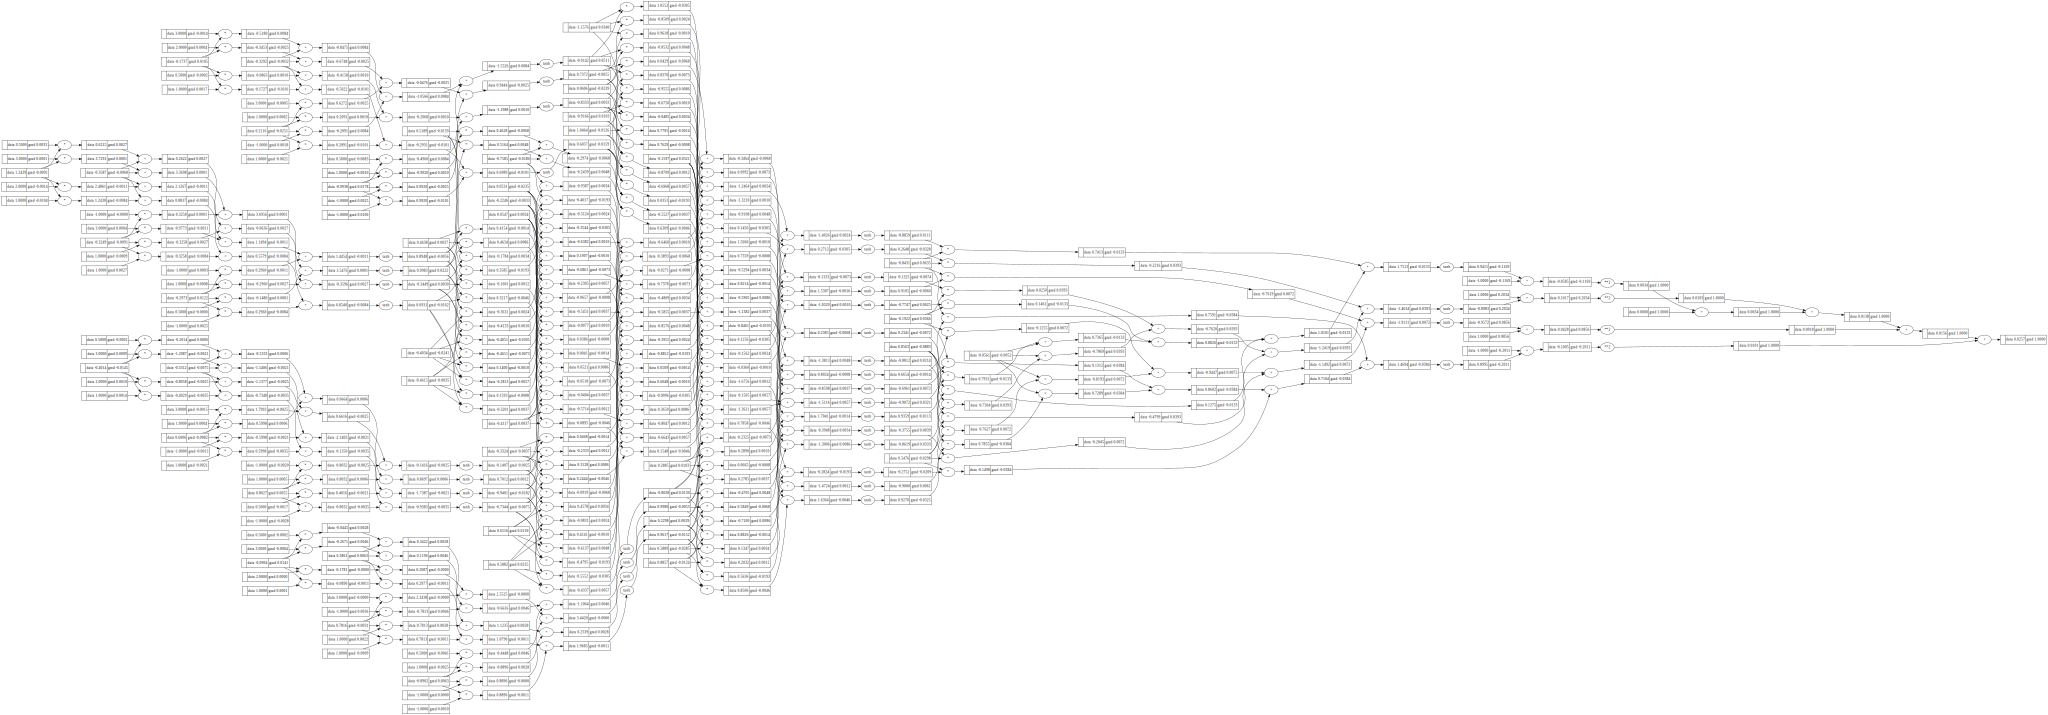

In [ ]:
draw_dot(loss)



1. **Does the input layer have weights and gradients?**

   - The input layer itself does not have weights or gradients. It simply represents the data you feed into the network. However, the connections from the input layer to the first hidden layer have weights. These weights, as well as the weights between other layers, will have associated gradients during the backpropagation phase.

2. **The input layer is: ... + weights?**

   - The `xs` you provided is just the data you're feeding into the network. The input layer doesn't modify this data. The transformation happens when this data is passed to the first hidden layer through weights. Each neuron in the first hidden layer has a set of weights connecting it to the input layer. These weights are what get updated during training.

3. **What gets calculated on the forward pass?**

   - In the forward pass, the following happens:
     1. The input data (`xs`) is passed to the first hidden layer.
     2. Each neuron in the first hidden layer computes a weighted sum of its inputs (using its weights and the input data) and then applies the activation function (in this case, `tanh`) to produce its output.
     3. This output is then passed to the next layer, and the process repeats until the output layer is reached.
     4. The final output of the network (`ypred`) is then computed.

4. **The shape is: 3-4-4-1**

   - This indicates the number of neurons in each layer. So, the input layer has 3 neurons (or units), the first hidden layer has 4 neurons, the second hidden layer has 4 neurons, and the output layer has 1 neuron.

In the provided code:

- **Forward Pass**: The input data (`xs`) is passed through the network, producing the predicted outputs (`ypred`). The difference between these predicted outputs and the true outputs (`ys`) is computed to produce the loss.

- **Backward Pass**: The gradient of the loss with respect to each weight and bias in the network is computed using backpropagation. This is where the `.backward()` method comes into play.

- **Update**: The weights and biases of the network are updated in the direction that reduces the loss. This is done using gradient descent, where the gradient computed in the backward pass is used to adjust each weight and bias.




1. **Where do the weights and gradient exist?**

   The weights and gradients exist on the connections between neurons. For instance, if neuron A in layer 1 connects to neuron B in layer 2, there's a weight for that specific connection. Each connection (from one neuron to another) has a specific weight.

2. **Are the weights inside the neurons or on the connections?**

   Conceptually, the weights are on the connections between neurons. However, in many implementations (including the one you provided), for convenience, weights are stored inside the "receiving" neuron. So, if neuron A in layer 1 connects to neuron B in layer 2, the weight for that connection might be stored in neuron B's data structure.

3. **Confusion about input layer and weights:**
   
   The input layer is a bit unique. It's just a placeholder for your input data and doesn't have any computation associated with it. The first place where computation happens is in the first hidden layer. When you pass data from the input layer to the first hidden layer, you're taking each input, multiplying it by a weight, and then summing all these weighted inputs in a neuron in the hidden layer. This summed value then gets passed through an activation function, producing the neuron's output.

   The key distinction here is that while neurons produce outputs based on their inputs and an activation function, the weights on the connections determine how much each input influences that output.

4. **Output node and weights:**

   The output node(s) indeed have weights - they have weights connecting them to the previous layer. What they don't have is "outgoing" weights since they're at the end of the network.





1. **Is \(-0.1\) the learning rate?**
    - Yes, \(-0.1\) is effectively serving as the learning rate in this example.

2. **Why is it negative?**
    - The learning rate is negative because during the update step, we want to move in the direction opposite to the gradient. The gradient indicates the direction of the steepest increase in the loss. To minimize the loss, we move our parameters (weights and biases) in the opposite direction. By subtracting a fraction of the gradient from our parameters, we're making small steps towards the direction that reduces the loss. The learning rate determines the size of these steps.

3. **What is the step size here?**
    - The step size refers to how much we adjust our parameters in the direction opposite to the gradient during each update. Here, the step size is determined by the product of the learning rate and the gradient. Specifically, the step size for each parameter is \($0.1 \times$ $\text{gradient of that parameter}$\).

4. **The \($x$\)s and \($w$\)s in \( $\text{activation}(\sum wx + b)$ \):**
    - The \( w \)'s are the weight parameters associated with the connections.
    - The \( x \)'s represent the inputs to the neuron. For the input layer, these are the data features. For hidden layers, these are the outputs of the previous layer's neurons.
    - For the input layer, \( x \)'s indeed never change since they represent your data. However, in hidden layers, \( x \)'s will change every forward pass since they depend on the outputs of the previous layer, which in turn depend on the weights and biases that get updated during training.

5. **Do the \( w \)'s and the biases change by the same amount for a particular neuron?**
    - Not necessarily. The amount by which \( w \)'s and biases change is determined by their respective gradients. While they might be updated in the same direction (i.e., both might increase or decrease), the magnitude of their change could differ depending on the size of their gradients.

6. **The update step in the provided code:**
    - The line `p.data += -0.1 * p.grad` updates the data (value) of each parameter \( p \) (either a weight or a bias) by subtracting \(0.1\) times its gradient. This is the gradient descent step which aims to minimize the loss by adjusting the parameters in the direction that leads to the steepest decrease in the loss.

Neural networks involve a lot of moving parts, and understanding backpropagation and parameter updates is central to grasping how they learn.